Using the csv files created in "LOB training data_V1" notebook (order book data + trades mid price), here trying to make the training data for Deep Learning, so that for each timestamp the feature columns are the closest n number of buy and sell orders either side of the Mid Traded Price  

In [0]:
import numpy as np
#import scipy as sc 
import pandas as pd

In [0]:
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
tf.test.gpu_device_name() #check if gpu is on

'/device:GPU:0'

In [0]:
from google.colab import drive

#This will prompt for authorization
drive.mount('/content/drive')

In [30]:
data = pd.read_csv('/content/drive/My Drive/Vega/MachineLearning/data/binance/train_df.csv') #path on Vega drive
#data = pd.read_csv('/content/drive/My Drive/Colab/train_df.csv') #path in my personal drive
print(data.shape)
data.head()

(19010150, 5)


,TimeStamp,Buy/Sell,Price,Volume,MidTraded
0,1.521332e+09,B,0.069430,0.864,0.069578
1,1.521332e+09,B,0.069429,0.327,0.069578
2,1.521332e+09,B,0.069416,0.090,0.069578
3,1.521332e+09,B,0.069406,0.084,0.069578
4,1.521332e+09,B,0.069404,0.269,0.069578


In [0]:
data.tail() #note the NaNs in the last row, this is because trades file (therefore MidTraded col) had one more timestamp 

,TimeStamp,Buy/Sell,Price,Volume,MidTraded
19010145,1.524764e+09,S,0.075861,0.323,0.071462
19010146,1.524764e+09,S,0.075865,0.020,0.071462
19010147,1.524764e+09,S,0.075868,0.100,0.071462
19010148,1.524764e+09,S,0.075869,2.388,0.071462
19010149,1.524765e+09,NaN,NaN,NaN,0.071526


Lets check the quantities before making any changes:

In [0]:
print("total bid orders: ", data[data['Buy/Sell'] == 'B']['Buy/Sell'].count())
print("total ask orders: ", data[data['Buy/Sell'] == 'S']['Buy/Sell'].count())

total bid orders:  9497147
total ask orders:  9513002


In [0]:
def orders_by_type(data, order_type):
  
  return data[data['Buy/Sell'] == order_type].set_index('TimeStamp')[['Price', 'Volume']]
  

In [0]:
buys = orders_by_type(data, 'B')

sells = orders_by_type(data, 'S')

Creating a dictionary of dictionaries in this format: {timestamp: {price: vol, price: vol, ...}, timestamp: {price: vol, price:vol, ..}, ...}  
to_dict() and tolist() by default sorts the values, here by Price per timestamp

In [0]:
buys_dict = buys.groupby(level=0).apply(lambda x: x.set_index('Price').squeeze().to_dict()).to_dict() 

In [0]:
sells_dict = sells.groupby(level='TimeStamp').apply(lambda x: x.set_index('Price').squeeze().to_dict()).to_dict()

In [9]:
#changing each of the above dicts to a list of lists, where data for each time step is stored as a list of (price, vol) pairs 
def price_vol(orders_dict):
  
  pri_vol = []
  for k, v in orders_dict.items():
    pri_vol.append(list(v.items()))
   
  return pri_vol

print("Lenght of buy lists: {}, sell lists: {}".format(len(price_vol(buys_dict)), len(price_vol(sells_dict))))

Lenght of buy lists: 9513, sell lists: 9514


In [10]:
#So Sells seems to have one extra timestamp (one timestmap with only sells and no buys), lets check if that's true 
b_times = buys.index.unique()
s_times = sells.index.unique()
extra = [t for t in s_times if t not in b_times]
print(extra)
data[data['TimeStamp'] == extra]

[1522124457.0]


,TimeStamp,Buy/Sell,Price,Volume,MidTraded
4372316,1.522124e+09,S,0.065074,0.033,0.058777
4372317,1.522124e+09,S,0.065074,0.033,0.058777


In [11]:
#getting the index of the timestamp with only sell orders to remove it from mid_traded price list for buy orders
ts = data.TimeStamp.unique().tolist()
extra_ts_idx = ts.index(1522124457.0)
print("index of the timestamp with only sell orders:", extra_ts_idx)

index of the timestamp with only sell orders: 2193


In [12]:
#mid traded price values for each timestamp. 
mid_traded = data.drop_duplicates('TimeStamp', keep='first').MidTraded.get_values().tolist()[:-1] #:-1 to exclude the last row with nans
len(mid_traded) 

9514

In [13]:
#will use mid_traded for sells, but deleting the extra ts for buys
buys_mid_traded = mid_traded.copy()
buys_mid_traded.pop(2193) #delete extra timestamp, ts[2193] = (0.058777) 

len(mid_traded), len(buys_mid_traded)

(9514, 9513)

-------------------------------------------------------------

Checking the shape of the buys and sells within some of the timestamps

In [0]:
buys_list = [] #a list of arrays where each array is the sorted buy prices per timestamp 
sells_list = [] #a list of arrays where each array is the sorted sell prices per timestamp 
b_ts = list(b_times)
s_ts = list(s_times)

for ind in b_ts:
  buys_list.append(buys.loc[ind, 'Price'].values) 

for ind in s_ts:
  sells_list.append(sells.loc[ind, 'Price'].values)
  
buys_list.insert(2193, []) #adding an empty list at index 2193 to buys

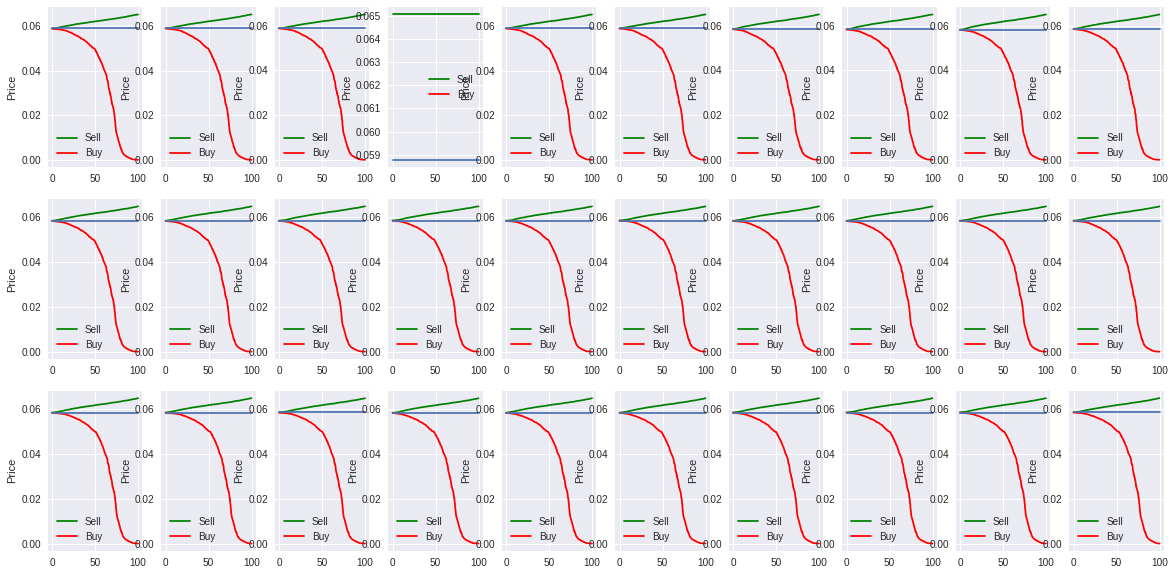

In [25]:
plt.figure(figsize=(20,10))
s = 2190 #index to start from (remember index 2193 only has sells)
for i in range(30):
  plt.subplot(3,10,i+1) #ax number should start from 1
  plt.plot(np.linspace(0, 100, num=len(sells_list[i+s])), sells_list[i+s], 'g', label="Sell")
  plt.plot(np.linspace(0, 100, num=len(buys_list[i+s])), buys_list[i+s], 'r', label="Buy")
  plt.plot(np.linspace(0, 100, num=len(sells_list[i+s])), [mid_traded[i+s] for _ in range(len(sells_list[i+s]))])
  plt.ylabel('Price')
  plt.legend()

Above shows buy/sell prices in the span of ~2 hours (20 x 5.5minute each ts). We can see how asks and bids remain reletively the same within this period. Change s variable to check prices starting from other timestamps

___________________________________________________

Also make another training set using next mid price, as well as by swapping 'B' with 'S' in the last section

In [0]:
#Takes 1xn orders from one side of the mid price
#If not enough orders available, generates prices at the WING of the data (outer side further from the mid)
#If mid falls in the middle takes 1xn from smaller values if Asks, and takes 1xn form the larger values if Bid
#**** NOTE there are places that diff (see below) can become 0, that's where the two last adjescent prices were equal and therefore the fake prices will be the same
def n_one_side_of_mid_to_wing(prix_vol, mid_price, n, order_type):
  '''
  Appends the mid traded price of each timestamp to its price_vol list, sorts it and returns n number of orders either side of the Mid traded price for 
  that time stamp. If there was less than n orders either side of the mid trade price, it will generate fake (price, 0 vol) orders form the last seen price. 
  '''
  length_before = len(prix_vol)        #lenght before appending the mid trade price
  prix_vol.append((mid_price, 0))      #append (mid trade price, 0 vol) to prix_vol list 
  length_after = len(prix_vol)         #lenght after appending the mid trade price
  prix_vol = sorted(prix_vol)          #sort by price
  idx = prix_vol.index((mid_price, 0)) #index of the mid trade price
  
  #print(prix_vol)
  #print(idx, mid_price)
  
  #mid price smaller than all other prices and we have enough orders to cover n samples [mid, 0.6, 0.7, 0.9, ...]
  if idx == 0 and length_before >= n: 
    ll = [prix_vol[i] for i in range(1, n+1)] #n of the smallest price (index 1) + index 1 to last price

  #mid price smaller than all other prices and there isnt enough orders to cover n [mid, 0.6, 0.7, 0.9] 
  elif idx == 0 and length_before < n: 
    diff = (prix_vol[-1][0] - prix_vol[-2][0])/2 #diff of the two largest prices at the wing divided by 2. below *i is to get different prices rather than same thing 
    ll = [prix_vol[i] for i in range(1, len(prix_vol))] + [(prix_vol[-1][0] + diff*i, 0) for i in range(1, n-length_before+1)] 
       
  #mid price larger than all other prices and enough samples to cover n [..., 0.4, 0.44, 0.6, mid]
  elif idx == length_after-1 and length_before >= n:
    ll = [prix_vol[i] for i in range(-n-1, -1)]
  
  #mid price larger than all other prices and there isnt enough orders to cover n [0.4, 0.44, 0.6, mid]  
  elif idx == length_after-1 and length_before < n: 
    diff = (prix_vol[1][0] - prix_vol[0][0])/2 #diff of the first two (smallest) prices. below /i to avoid going below zero 
    ll = [(prix_vol[0][0] - diff/i, 0) for i in range(1, n-length_before+1)] + [prix_vol[i] for i in range(0, len(prix_vol)-1)] 
  
  else: #mid price falls in between other orders
    if order_type == 'S': #take the values smaller than mid  
      if idx >= n:
        ll = [prix_vol[i] for i in range(idx-n, idx)]
      else:
        diff = (prix_vol[1][0] - prix_vol[0][0])/2
        ll = [(prix_vol[0][0] - diff/i, 0) if i < 0 else prix_vol[i] for i in range(idx-n, idx)] 
    
    if order_type == 'B': #take values larger than mid
      if length_after-idx > n:
        ll = [prix_vol[i] for i in range(idx+1, idx+n+1)]  
      else:   
        diff = (prix_vol[-1][0] - prix_vol[-2][0])/2
        ll = [prix_vol[i] for i in range(idx+1, length_after)] + [(prix_vol[-1][0] + diff*i, 0) for i in range(1, n-(length_after-idx-1)+1)]

  return [l_1 for l2 in ll for l_1 in l2] #change the list of (price, vol) tuples to a flat list of [price, vol, price, vol, ...]

In [0]:
#testing results ***un-comment the print statements in the function
#n_one_side_of_mid_to_wing(price_vol(sells_dict)[0], mid_traded[0], 20, 'B') 

In [0]:
def all_orders_around_mid(pri_vol_lists, mid_list, n, order_type):
  price_vols = [] 
  for i in range(len(pri_vol_lists)):
    price_vols.append(n_one_side_of_mid_to_wing(pri_vol_lists[i], mid_list[i], n, order_type))
  return price_vols

In [0]:
buy_orders = price_vol(buys_dict)

buy_orders = all_orders_around_mid(buy_orders, buys_mid_traded, 20, 'B')

buy_orders.insert(2193, [0]*40) #adding a list with length 40 to index 2193, to make buys and sells same length

In [0]:
sell_orders = price_vol(sells_dict)

sell_orders = all_orders_around_mid(sell_orders, mid_traded, 20, 'S')

In [41]:
#checking a few results
print(buy_orders[1001])
print(mid_traded[1001])
print(sell_orders[1001])

[0.063093, 0.523, 0.063096, 0.465, 0.063097, 0.194, 0.063099, 0.557, 0.0631, 34.85, 0.063101, 0.469, 0.063105, 12.416, 0.063111, 3.691, 0.063113, 0.6759999999999999, 0.06311900000000001, 2.445, 0.063126, 0.185, 0.06312999999999999, 0.478, 0.06313099999999999, 2.149, 0.063136, 0.374, 0.063139, 0.2, 0.06314, 0.4, 0.06314600000000001, 0.775, 0.063149, 0.544, 0.06315, 2.266, 0.063153, 1.146]
0.0631865
[0.063225, 0.238, 0.063226, 0.017, 0.06322699999999999, 1.0, 0.06322799999999999, 0.856, 0.063237, 1.0, 0.063238, 0.032, 0.063253, 1.243, 0.06325499999999999, 15.41, 0.063263, 0.026, 0.06326799999999999, 2.58, 0.063274, 0.192, 0.06328500000000001, 16.329, 0.063287, 112.495, 0.063288, 90.515, 0.063289, 0.623, 0.06329, 237.505, 0.063292, 0.123, 0.063295, 0.046, 0.063299, 1.499, 0.0633, 0.017]


In [0]:
#extending each inner list in the buys with that of sells  
for i in range(len(buy_orders)):
  buy_orders[i].extend(sell_orders[i])

In [0]:
#checking the result
print(buy_orders[1001])

[0.063093, 0.523, 0.063096, 0.465, 0.063097, 0.194, 0.063099, 0.557, 0.0631, 34.85, 0.063101, 0.469, 0.063105, 12.416, 0.063111, 3.691, 0.063113, 0.6759999999999999, 0.06311900000000001, 2.445, 0.063126, 0.185, 0.06312999999999999, 0.478, 0.06313099999999999, 2.149, 0.063136, 0.374, 0.063139, 0.2, 0.06314, 0.4, 0.06314600000000001, 0.775, 0.063149, 0.544, 0.06315, 2.266, 0.063153, 1.146, 0.063225, 0.238, 0.063226, 0.017, 0.06322699999999999, 1.0, 0.06322799999999999, 0.856, 0.063237, 1.0, 0.063238, 0.032, 0.063253, 1.243, 0.06325499999999999, 15.41, 0.063263, 0.026, 0.06326799999999999, 2.58, 0.063274, 0.192, 0.06328500000000001, 16.329, 0.063287, 112.495, 0.063288, 90.515, 0.063289, 0.623, 0.06329, 237.505, 0.063292, 0.123, 0.063295, 0.046, 0.063299, 1.499, 0.0633, 0.017]


In [0]:
ts.pop(9514) #deleting last time_stamp with nan values 

1524764544.0

In [0]:
#creating column names for the new dataframe
cols = [["B_P"+str(i+1)]+["B_V"+str(i+1)] for i in range(20)] + [["S_P"+str(i+1)]+["S_V"+str(i+1)] for i in range(20)]
columns = [c for cc in cols for c in cc]

In [0]:
data_dict = {ts[i]:buy_orders[i] for i in range(len(ts))}
train_df_80 = pd.DataFrame.from_dict(data_dict, orient='index')
train_df_80.columns = columns
train_df_80['Mid'] = mid_traded

pd.set_option('display.max_columns', 81) 
train_df_80

,B_P1,B_V1,B_P2,B_V2,B_P3,B_V3,B_P4,B_V4,B_P5,B_V5,B_P6,B_V6,B_P7,B_V7,B_P8,B_V8,B_P9,B_V9,B_P10,B_V10,B_P11,B_V11,B_P12,B_V12,B_P13,B_V13,B_P14,B_V14,B_P15,B_V15,B_P16,B_V16,B_P17,B_V17,B_P18,B_V18,B_P19,B_V19,B_P20,B_V20,S_P1,S_V1,S_P2,S_V2,S_P3,S_V3,S_P4,S_V4,S_P5,S_V5,S_P6,S_V6,S_P7,S_V7,S_P8,S_V8,S_P9,S_V9,S_P10,S_V10,S_P11,S_V11,S_P12,S_V12,S_P13,S_V13,S_P14,S_V14,S_P15,S_V15,S_P16,S_V16,S_P17,S_V17,S_P18,S_V18,S_P19,S_V19,S_P20,S_V20,Mid
1.521332e+09,0.069306,0.334,0.069309,0.015,0.069313,0.367,0.069314,4.328,0.069316,0.400,0.069319,0.016,0.069337,0.299,0.069343,0.275,0.069360,0.130,0.069363,0.109,0.069373,20.000,0.069374,0.536,0.069376,0.074,0.069378,0.040,0.069400,1.219,0.069404,0.269,0.069406,0.084,0.069416,0.090,0.069429,0.327,0.069430,0.864,0.069556,0.000,0.069556,0.000,0.069556,0.000,0.069556,0.000,0.069556,0.000,0.069556,0.000,0.069556,0.000,0.069556,0.000,0.069556,0.000,0.069556,0.000,0.069556,0.000,0.069556,0.000,0.069556,0.000,0.069556,1.724,0.069557,0.283,0.069558,4.166,0.069559,0.870,0.069560,23.200,0.069568,0.372,0.069569,1.248,0.069578
1.521333e+09,0.069009,0.334,0.069010,0.279,0.069011,0.030,0.069012,0.016,0.069016,0.350,0.069030,0.058,0.069039,0.320,0.069042,0.539,0.069050,0.500,0.069054,0.015,0.069065,0.179,0.069076,0.129,0.069082,0.184,0.069095,0.261,0.069099,0.370,0.069100,5.115,0.069105,3.040,0.069106,3.441,0.069160,0.471,0.069161,0.328,0.069216,0.000,0.069216,0.000,0.069216,0.000,0.069216,0.000,0.069216,0.000,0.069216,0.000,0.069217,0.000,0.069217,0.000,0.069217,0.000,0.069218,0.000,0.069219,0.000,0.069221,0.000,0.069226,0.000,0.069215,1.451,0.069237,0.500,0.069238,0.001,0.069241,0.278,0.069244,1.933,0.069247,0.536,0.069250,19.809,0.069264
1.521333e+09,0.068680,1.000,0.068690,1.001,0.068694,0.475,0.068695,2.238,0.068700,0.111,0.068708,0.350,0.068710,5.000,0.068715,0.050,0.068733,0.275,0.068739,0.370,0.068740,1.149,0.068741,0.410,0.068743,0.390,0.068749,0.015,0.068750,0.404,0.068751,0.080,0.068778,5.188,0.068779,2.916,0.068780,0.676,0.068781,0.390,0.068873,0.000,0.068873,0.000,0.068873,0.000,0.068873,0.000,0.068873,0.000,0.068873,0.000,0.068873,0.000,0.068873,0.000,0.068873,0.000,0.068873,0.000,0.068873,0.000,0.068873,0.000,0.068873,0.000,0.068874,0.000,0.068873,1.528,0.068874,1.332,0.068875,1.362,0.068879,0.075,0.068896,1.400,0.068899,5.695,0.068901
1.521333e+09,0.068332,0.147,0.068340,1.317,0.068341,0.159,0.068350,4.000,0.068358,5.000,0.068359,0.365,0.068368,1.034,0.068371,0.261,0.068378,0.299,0.068390,0.320,0.068400,0.897,0.068409,0.705,0.068411,0.320,0.068413,0.330,0.068424,0.984,0.068452,0.808,0.068465,25.135,0.068467,0.897,0.068470,0.247,0.068473,0.523,0.068547,0.481,0.068548,3.345,0.068550,0.350,0.068560,0.527,0.068592,0.758,0.068601,0.889,0.068602,0.841,0.068603,0.759,0.068606,2.014,0.068620,2.460,0.068642,0.100,0.068644,5.200,0.068649,0.275,0.068663,0.159,0.068664,0.334,0.068670,0.684,0.068673,0.635,0.068678,5.586,0.068679,0.056,0.068680,2.021,0.068488
1.521334e+09,0.068062,0.320,0.068064,0.819,0.068067,0.400,0.068069,0.040,0.068070,0.707,0.068071,1.049,0.068074,0.200,0.068075,0.015,0.068090,0.533,0.068095,0.090,0.068096,0.293,0.068099,0.335,0.068100,1.191,0.068105,0.673,0.068110,1.182,0.068115,0.262,0.068118,0.110,0.068140,2.142,0.068148,0.507,0.068155,0.575,0.068233,0.000,0.068233,0.000,0.068233,0.000,0.068233,0.000,0.068233,0.000,0.068233,0.000,0.068233,0.000,0.068233,0.000,0.068233,0.000,0.068233,0.000,0.068233,0.000,0.068233,0.000,0.068233,0.000,0.068233,0.000,0.068233,0.000,0.068234,0.000,0.068233,4.103,0.068234,1.311,0.068236,1.575,0.068245,0.939,0.068260
1.521334e+09,0.068187,1.937,0.068200,0.361,0.068202,0.078,0.068211,0.430,0.068230,2.965,0.068232,0.434,0.068233,3.322,0.068234,0.001,0.068235,0.000,0.068235,0.000,0.068236,0.000,0.068236,0.000,0.068237,0.000,0.068237,0.000,0.068238,0.000,0.068238,0.000,0.068239,0.000,0.068239,0.000,0.068240,0.000,0.068240,0.000,0.068296,0.001,0.068305,0.074,0.068334,6.295,0.068335,0.269,0.068346,0.170,0.068353,0.543,0.068357,0.230,0.068362,0.160,0.06

In [0]:
#0 vols have been created by me where data near mid did not exist. Chechikng how many rows have fake price (0 vol)  
#train_df_80[(train_df_80['B_V1'] == 0) | (train_df_80['B_V20'] == 0) | (train_df_80['S_V1'] == 0) | (train_df_80['S_V20'] == 0)]

In [0]:
#test
#n_one_side_of_mid_to_wing(price_vol(sells_dict)[1], mid_traded[1], 20, 'S') 

In [0]:
train_df_80.to_csv('/content/drive/My Drive/Vega/MachineLearning/data/binance/train_df_80.csv')

Making a training data using next mid price (doing all the above steps just with mid price starting from 2nd value (index 1) to the end) 

In [0]:
next_mid = data.drop_duplicates('TimeStamp', keep='first').MidTraded.get_values().tolist()[1:] #starting from 2nd value (index 1)

buys_next_mid = next_mid.copy()
buys_next_mid.pop(2193) #delete extra timestamp, ts[2193] = (0.058777) 

0.058888

In [0]:
buy_orders = price_vol(buys_dict)

buy_orders = all_orders_around_mid(buy_orders, buys_next_mid, 20, 'B')

buy_orders.insert(2193, [0]*40) #adding a list with length 40 to index 2193, to make buys and sells same length

In [0]:
sell_orders = price_vol(sells_dict)

sell_orders = all_orders_around_mid(sell_orders, next_mid, 20, 'S')

In [0]:
for i in range(len(buy_orders)):
  buy_orders[i].extend(sell_orders[i])

In [0]:
print(buy_orders[2])

[0.0685, 14.064, 0.06851, 50.0, 0.068516, 0.4, 0.068524, 0.4, 0.068535, 1.4580000000000002, 0.06854099999999999, 5.0, 0.06854500000000001, 0.051, 0.068549, 0.146, 0.068553, 0.219, 0.06856, 0.4, 0.068562, 0.056, 0.068573, 3.0, 0.068589, 0.2, 0.068591, 0.545, 0.068595, 0.334, 0.068596, 0.022, 0.0686, 0.054000000000000006, 0.068602, 0.12, 0.068608, 0.5429999999999999, 0.068609, 0.261, 0.068873, 1.528, 0.068874, 1.332, 0.068875, 1.362, 0.068879, 0.075, 0.068896, 1.4, 0.068899, 5.695, 0.06891, 0.244, 0.068922, 2.261, 0.06892899999999999, 2.818, 0.06893200000000001, 0.334, 0.06893300000000001, 0.759, 0.06893400000000001, 6.533, 0.068938, 0.861, 0.068939, 0.913, 0.06894600000000001, 3.2880000000000003, 0.068949, 0.5589999999999999, 0.06895, 0.299, 0.068951, 0.13, 0.068954, 0.4, 0.068957, 0.513]


In [0]:
ts.pop(9514) #deleting last time_stamp with nan

data_dict = {ts[i]:buy_orders[i] for i in range(len(ts))}
train_df_80_next = pd.DataFrame.from_dict(data_dict, orient='index')
train_df_80_next.columns = columns
train_df_80_next['next_Mid'] = next_mid

pd.set_option('display.max_columns', 81) 
train_df_80_next

,B_P1,B_V1,B_P2,B_V2,B_P3,B_V3,B_P4,B_V4,B_P5,B_V5,B_P6,B_V6,B_P7,B_V7,B_P8,B_V8,B_P9,B_V9,B_P10,B_V10,B_P11,B_V11,B_P12,B_V12,B_P13,B_V13,B_P14,B_V14,B_P15,B_V15,B_P16,B_V16,B_P17,B_V17,B_P18,B_V18,B_P19,B_V19,B_P20,B_V20,S_P1,S_V1,S_P2,S_V2,S_P3,S_V3,S_P4,S_V4,S_P5,S_V5,S_P6,S_V6,S_P7,S_V7,S_P8,S_V8,S_P9,S_V9,S_P10,S_V10,S_P11,S_V11,S_P12,S_V12,S_P13,S_V13,S_P14,S_V14,S_P15,S_V15,S_P16,S_V16,S_P17,S_V17,S_P18,S_V18,S_P19,S_V19,S_P20,S_V20,next_Mid
1.521332e+09,0.069267,0.381,0.069274,0.350,0.069275,0.597,0.069278,2.165,0.069281,0.400,0.069282,0.039,0.069283,0.031,0.069289,0.022,0.069300,18.525,0.069306,0.334,0.069309,0.015,0.069313,0.367,0.069314,4.328,0.069316,0.400,0.069319,0.016,0.069337,0.299,0.069343,0.275,0.069360,0.130,0.069363,0.109,0.069373,20.000,0.069556,1.724,0.069557,0.283,0.069558,4.166,0.069559,0.870,0.069560,23.200,0.069568,0.372,0.069569,1.248,0.069596,0.400,0.069599,0.400,0.069600,0.824,0.069609,0.320,0.069610,9.109,0.069612,0.261,0.069620,0.350,0.069626,0.989,0.069628,0.016,0.069636,0.159,0.069637,2.893,0.069642,0.334,0.069662,0.007,0.069264
1.521333e+09,0.068904,1.000,0.068915,0.072,0.068916,3.000,0.068918,0.770,0.068920,1.000,0.068934,21.730,0.068955,0.234,0.068964,6.072,0.068984,0.387,0.068990,0.435,0.068997,0.400,0.068998,0.918,0.069000,33.989,0.069001,0.189,0.069002,0.188,0.069009,0.334,0.069010,0.279,0.069011,0.030,0.069012,0.016,0.069016,0.350,0.069215,1.451,0.069237,0.500,0.069238,0.001,0.069241,0.278,0.069244,1.933,0.069247,0.536,0.069250,19.809,0.069275,10.000,0.069276,0.819,0.069291,0.994,0.069294,2.500,0.069300,62.200,0.069305,0.847,0.069309,2.400,0.069310,0.788,0.069313,0.400,0.069317,1.400,0.069324,6.345,0.069328,0.334,0.069330,1.275,0.068901
1.521333e+09,0.068500,14.064,0.068510,50.000,0.068516,0.400,0.068524,0.400,0.068535,1.458,0.068541,5.000,0.068545,0.051,0.068549,0.146,0.068553,0.219,0.068560,0.400,0.068562,0.056,0.068573,3.000,0.068589,0.200,0.068591,0.545,0.068595,0.334,0.068596,0.022,0.068600,0.054,0.068602,0.120,0.068608,0.543,0.068609,0.261,0.068873,1.528,0.068874,1.332,0.068875,1.362,0.068879,0.075,0.068896,1.400,0.068899,5.695,0.068910,0.244,0.068922,2.261,0.068929,2.818,0.068932,0.334,0.068933,0.759,0.068934,6.533,0.068938,0.861,0.068939,0.913,0.068946,3.288,0.068949,0.559,0.068950,0.299,0.068951,0.130,0.068954,0.400,0.068957,0.513,0.068488
1.521333e+09,0.068270,0.334,0.068276,0.545,0.068277,5.000,0.068281,0.275,0.068292,0.387,0.068300,15.701,0.068302,0.350,0.068310,0.130,0.068312,29.316,0.068322,0.017,0.068332,0.147,0.068340,1.317,0.068341,0.159,0.068350,4.000,0.068358,5.000,0.068359,0.365,0.068368,1.034,0.068371,0.261,0.068378,0.299,0.068390,0.320,0.068547,0.481,0.068548,3.345,0.068550,0.350,0.068560,0.527,0.068592,0.758,0.068601,0.889,0.068602,0.841,0.068603,0.759,0.068606,2.014,0.068620,2.460,0.068642,0.100,0.068644,5.200,0.068649,0.275,0.068663,0.159,0.068664,0.334,0.068670,0.684,0.068673,0.635,0.068678,5.586,0.068679,0.056,0.068680,2.021,0.068260
1.521334e+09,0.068062,0.320,0.068064,0.819,0.068067,0.400,0.068069,0.040,0.068070,0.707,0.068071,1.049,0.068074,0.200,0.068075,0.015,0.068090,0.533,0.068095,0.090,0.068096,0.293,0.068099,0.335,0.068100,1.191,0.068105,0.673,0.068110,1.182,0.068115,0.262,0.068118,0.110,0.068140,2.142,0.068148,0.507,0.068155,0.575,0.068233,4.103,0.068234,1.311,0.068236,1.575,0.068245,0.939,0.068261,1.217,0.068276,19.434,0.068290,2.021,0.068307,7.108,0.068322,0.818,0.068326,0.190,0.068329,1.159,0.068344,0.159,0.068345,5.130,0.068353,0.193,0.068363,0.514,0.068364,3.131,0.068376,0.130,0.068377,0.240,0.068378,0.781,0.068380,5.000,0.068179
1.521334e+09,0.068211,0.430,0.068230,2.965,0.068232,0.434,0.068233,3.322,0.068234,0.001,0.068235,0.000,0.068235,0.000,0.068236,0.000,0.068236,0.000,0.068237,0.000,0.068237,0.000,0.068238,0.000,0.068238,0.000,0.068239,0.000,0.068239,0.000,0.068240,0.000,0.068240,0.000,0.068241,0.000,0.068241,0.000,0.068242,0.000,0.068296,0.001,0.068305,0.074,0.068334,6.295,0.068335,0.269,0.068346,0.170,0.068353,0.543,0.068357,0.230,0.068

In [0]:
#train_df_80_next[(train_df_80_next['B_V1'] == 0) | (train_df_80_next['B_V20'] == 0) | (train_df_80_next['S_V1'] == 0) | (train_df_80_next['S_V20'] == 0)]

In [0]:
train_df_80_next.to_csv('/content/drive/My Drive/Vega/MachineLearning/data/binance/train_df_80_next.csv')